# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [20]:
# uncomment to install umap
# !pip install umap-learn

### Load libraries

In [231]:
import csv
import numpy as np
import pandas as pd



from matplotlib import pyplot as plt
import sklearn
# metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
# feature selection
from sklearn.feature_selection import RFE, RFECV, chi2, SelectKBest
# models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# umap
import umap.umap_ as umap

# scaling
from sklearn.preprocessing import StandardScaler

### Load data

In [232]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

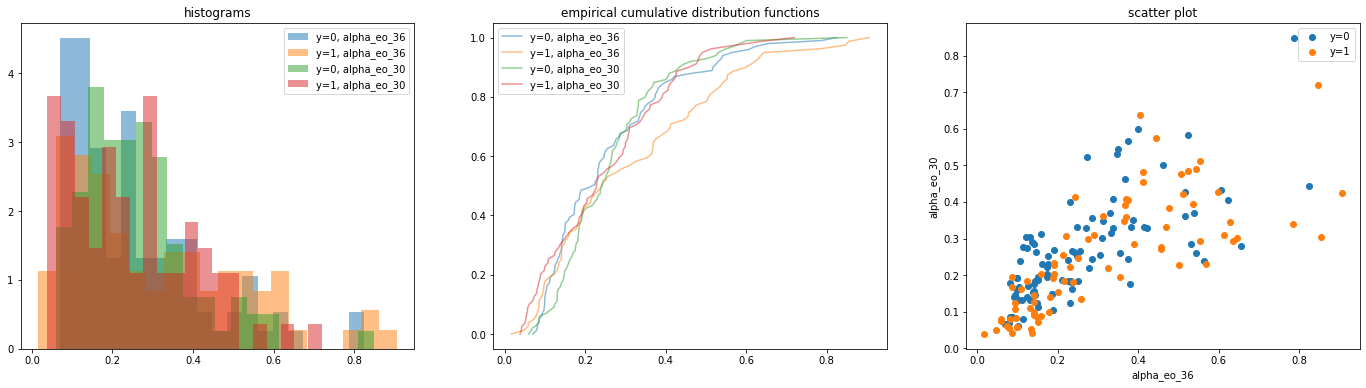

In [233]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

## Center and rescale the data

In [234]:
# rescaled data
scaler = StandardScaler().fit(X)
nX = scaler.transform(X)
nX.shape

(180, 432)

### PCA

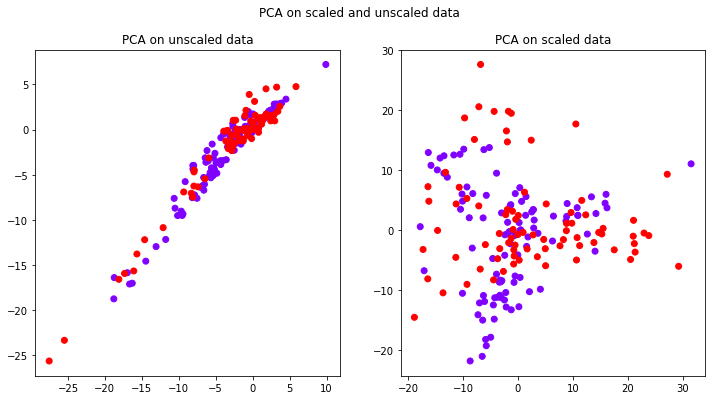

In [97]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle("PCA on scaled and unscaled data")
# unscaled
pca_unscaled = sklearn.decomposition.PCA(n_components=2).fit(X)
pca_unscaled_display = pca.transform(X)
# scaled
pca_scaled = sklearn.decomposition.PCA(n_components=2).fit(nX)
pca_scaled_display = pca.transform(nX)

ax1.title.set_text("PCA on unscaled data")
ax1.scatter(pca_unscaled_display[:,0], pca_unscaled_display[:,1], c=y, cmap='rainbow')

ax2.title.set_text("PCA on scaled data")
ax2.scatter(pca_scaled_display[:,0], pca_scaled_display[:,1], c=y, cmap='rainbow')



### UMAP

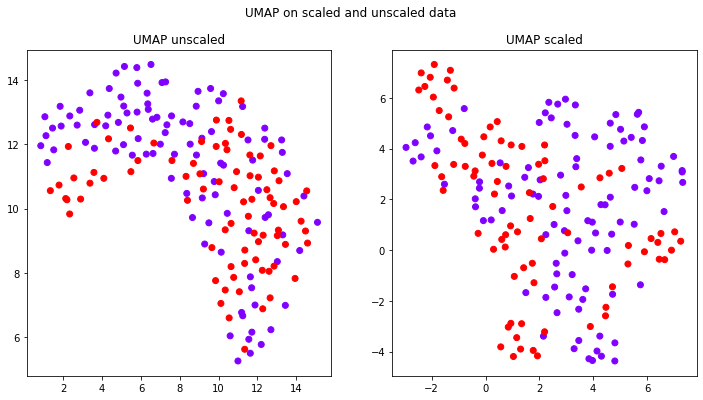

In [101]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle("UMAP on scaled and unscaled data")

# perform UMAP to get a better sense of the data
umap  = umap.UMAP(min_dist=0.9,n_components=2)
# unscaled
unscaled_display_2d = umap.fit_transform(X)

# scaled
scaled_display_2d = umap.fit_transform(nX)

ax1.title.set_text("UMAP unscaled")
ax1.scatter(unscaled_display_2d[:,0], unscaled_display_2d[:,1], c=y, cmap='rainbow')


ax2.title.set_text("UMAP scaled")
ax2.scatter(scaled_display_2d[:,0], scaled_display_2d[:,1], c=y, cmap='rainbow')


### Defining models and evaluation function
Courtesy of Hammad

In [105]:
models = [
          ('LogReg', LogisticRegression(max_iter=200)), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
        ]
# base model
clf = SVC(kernel='linear')
kf = KFold(n_splits=18, shuffle=False)


In [106]:
# use hammad's evaluate function
def evaluate(models, data, kf):
    results = []
    for name, model in models:
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        # train loop
        for train_index, test_index in kf.split(data):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)

            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": name,
            "accuracy": np.mean(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [103]:
evaluate(models, X, kf)

/Users/sebinthomas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.855556,0.8250,0.88,0.85250
1,RF,0.811111,0.7750,0.84,0.80750
2,KNN,0.688889,0.5875,0.77,0.67875
3,SVM,0.661111,0.6875,0.64,0.66375
4,GNB,0.750000,0.6625,0.82,0.74125


In [104]:
evaluate(models, nX, kf) # with centering and scaling

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.927778,0.9125,0.94,0.92625
1,RF,0.822222,0.7750,0.86,0.81750
2,KNN,0.855556,0.7875,0.91,0.84875
3,SVM,0.866667,0.8250,0.90,0.86250
4,GNB,0.750000,0.6625,0.82,0.74125


### RFECV on data

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

Number of features :  61


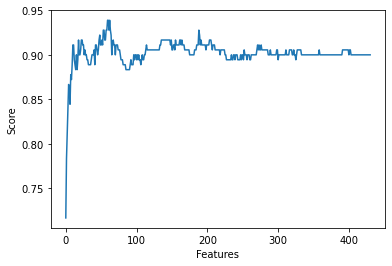

In [108]:
plt.figure()

rfecv = RFECV(estimator=clf, step=1, scoring='accuracy', cv= kf.split(nX), min_features_to_select=2)
rfecv.fit(nX, y)

print("Number of features : ", rfecv.n_features_)

plt.xlabel("Features")
plt.ylabel("Score")
plt.plot(range(len(rfecv.grid_scores_)), rfecv.grid_scores_)
plt.show()

### Pearson correlation

why it might not be a great idea
https://stats.stackexchange.com/questions/291210/is-it-wrong-to-choose-features-based-on-p-value/291239#291239

How to do it using dataframes
https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

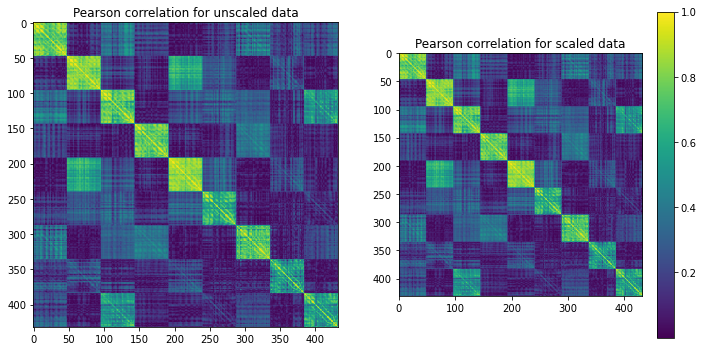

In [181]:
dfX = pd.DataFrame(X, columns=feature_names)
dfnX = pd.DataFrame(nX, columns=feature_names)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.title.set_text("Pearson correlation for unscaled data")

bx = fig.add_subplot(122)
bx.title.set_text("Pearson correlation for scaled data")

# take absolute value of the correlation matrix
# correlation goes from -1 to 1
correl_unscaled = dfX.corr().abs()
correl_scaled = dfnX.corr().abs()

aim = ax.imshow(correl_unscaled)
bim = bx.imshow(correl_scaled)
fig.colorbar(bim)

In [195]:
upper = correl_scaled.where(np.triu(np.ones(correl_scaled.shape), k=1).astype(bool))

# the threshold to drop columns is a hyperparameter that you can change
cols_to_drop = [col for col in upper.columns if any(upper[col] > 0.96)]

print("Cols to drop: ", len(cols_to_drop))
# print(dfnX[cols_to_drop])
pearson_df = dfnX.drop(dfnX[cols_to_drop], axis=1)
# print(dropped_df)
pearson_X = pearson_df.to_numpy()
pearson_X.shape

Cols to drop:  54


(180, 378)

In [196]:
evaluate(models, pearson_X, kf)

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.900000,0.8750,0.92,0.89750
1,RF,0.822222,0.8125,0.83,0.82125
2,KNN,0.872222,0.8125,0.92,0.86625
3,SVM,0.877778,0.8500,0.90,0.87500
4,GNB,0.766667,0.6875,0.83,0.75875


### Pearson + RFECV



Number of features :  112


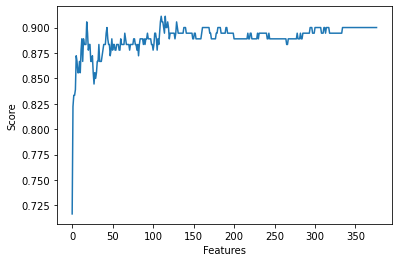

In [241]:
plt.figure()
plt.suptitle("Pearson correlation + RFECV")
rfecv = RFECV(estimator=clf, step=1, scoring='accuracy', cv= kf.split(pearson_X), min_features_to_select=2)
rfecv.fit(pearson_X, y)

print("Number of features : ", rfecv.n_features_)

plt.xlabel("Features")
plt.ylabel("Score")
plt.plot(range(len(rfecv.grid_scores_)), rfecv.grid_scores_)
plt.show()

In [242]:
rfe_sel = RFE(clf, n_features_to_select=rfecv.n_features_, step=1)
rfe_sel = rfe_sel.fit(pearson_X, y)
pearson_rfe_X = pearson_X[:, rfe_sel.support_]
evaluate(models, pearson_rfe_X, kf)


,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.994444,1.0000,0.99,0.99500
1,RF,0.838889,0.7875,0.88,0.83375
2,KNN,0.872222,0.8375,0.90,0.86875
3,SVM,0.922222,0.9125,0.93,0.92125
4,GNB,0.816667,0.7375,0.88,0.80875


# $ Chi^2\: Test$

(180, 60)

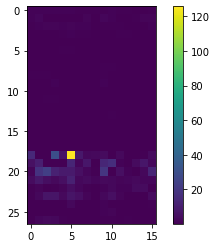

In [229]:
plt.figure()

chi2_model = SelectKBest(score_func=chi2, k=60)
# cannot use centered X as chi2 expects positive values
fit = chi2_model.fit(X, y)
fit.scores_.shape

plt.imshow(fit.scores_.reshape(27, 16))
plt.colorbar()
chi_X = chi2_model.fit_transform(X, y)
chi_X.shape

In [230]:
evaluate(models, chi_X, kf)

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.783333,0.7750,0.79,0.78250
1,RF,0.744444,0.7000,0.78,0.74000
2,KNN,0.750000,0.6500,0.83,0.74000
3,SVM,0.644444,0.6875,0.61,0.64875
4,GNB,0.711111,0.5250,0.86,0.69250


### Chi2 + RFECV

Number of features :  19


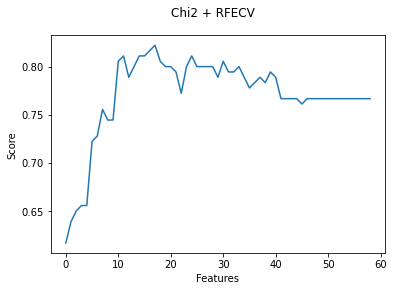

In [243]:
plt.figure()
plt.suptitle("Chi2 + RFECV")
rfecv = RFECV(estimator=clf, step=1, scoring='accuracy', cv= kf.split(chi_X), min_features_to_select=2)
rfecv.fit(chi_X, y)

print("Number of features : ", rfecv.n_features_)

plt.xlabel("Features")
plt.ylabel("Score")
plt.plot(range(len(rfecv.grid_scores_)), rfecv.grid_scores_)
plt.show()

In [245]:
rfe_sel = RFE(clf, n_features_to_select=rfecv.n_features_, step=1)
rfe_sel = rfe_sel.fit(chi_X, y)
chi_rfe_X = chi_X[:, rfe_sel.support_]
evaluate(models, chi_rfe_X, kf)


,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.844444,0.8375,0.85,0.84375
1,RF,0.772222,0.7125,0.82,0.76625
2,KNN,0.661111,0.5500,0.75,0.65000
3,SVM,0.622222,0.6250,0.62,0.62250
4,GNB,0.727778,0.5875,0.84,0.71375
